# Position-Velocity Diagrams from Disks

## Authors
Adam Ginsburg, Eric Koch, Derek Homeier

## Learning Goals
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [pvextractor](https://pvextractor.readthedocs.io/en/latest/)
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [reproject](https://reproject.readthedocs.io/en/stable/) via [spectral-cube](http://spectral-cube.readthedocs.io/) using a [region](https://astropy-regions.readthedocs.io/) mask

## Keywords
cube, pv-diagram

## Summary
In this tutorial, we will extract position-velocity (PV) diagrams from a cube of a disk and plot them.

# Requirements

!pip install --upgrade spectral-cube git+https://github.com/radio-astro-tools/pvextractor.git@61e118aaf28e2d746deeccf06af8fdd7f405b815 radio-beam regions reproject

!pip install --upgrade git+https://github.com/ericpre/matplotlib.git@c394be8

!pip install --upgrade git+https://github.com/dhomeier/regions.git@f38f2cb

In [1]:
import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube
from astropy import wcs

In [2]:
# keep an interactive handle to the plot windows until they are switched off
%matplotlib notebook
import pylab as pl
# set so that these display properly on black backgrounds
pl.rcParams['figure.facecolor']='w'

In [3]:
import radio_beam

In [4]:
from astropy import units as u

We download a 2cube from the MAPS survey:

In [5]:
filename = 'HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits'
if not os.path.exists(filename):
    try:
        filename = download_file('ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec/HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', cache=True, timeout=10)
    except:
        import ftplib
        ftp = ftplib.FTP('ftp.cv.nrao.edu')
        ftp.login()
        ftp.cwd('NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec')
        with open('HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', 'wb') as fp:
            ftp.retrbinary('RETR HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', fp.write)
        ftp.quit()    

We load the cube using the `dask` backend, which allows for some parallelization:

In [6]:
cube = SpectralCube.read(filename, use_dask=True)

In [7]:
cube

DaskSpectralCube with shape=(127, 2048, 2048) and unit=Jy / beam and chunk size (127, 512, 512):
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   269.082528 deg:  269.094790 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -21.961977 deg:  -21.950605 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [8]:
mx = cube.max(axis=0)

A quick look at the image cube shows that there is a disk rotated about 45 degrees in the center of the frame:

<IPython.core.display.Javascript object>


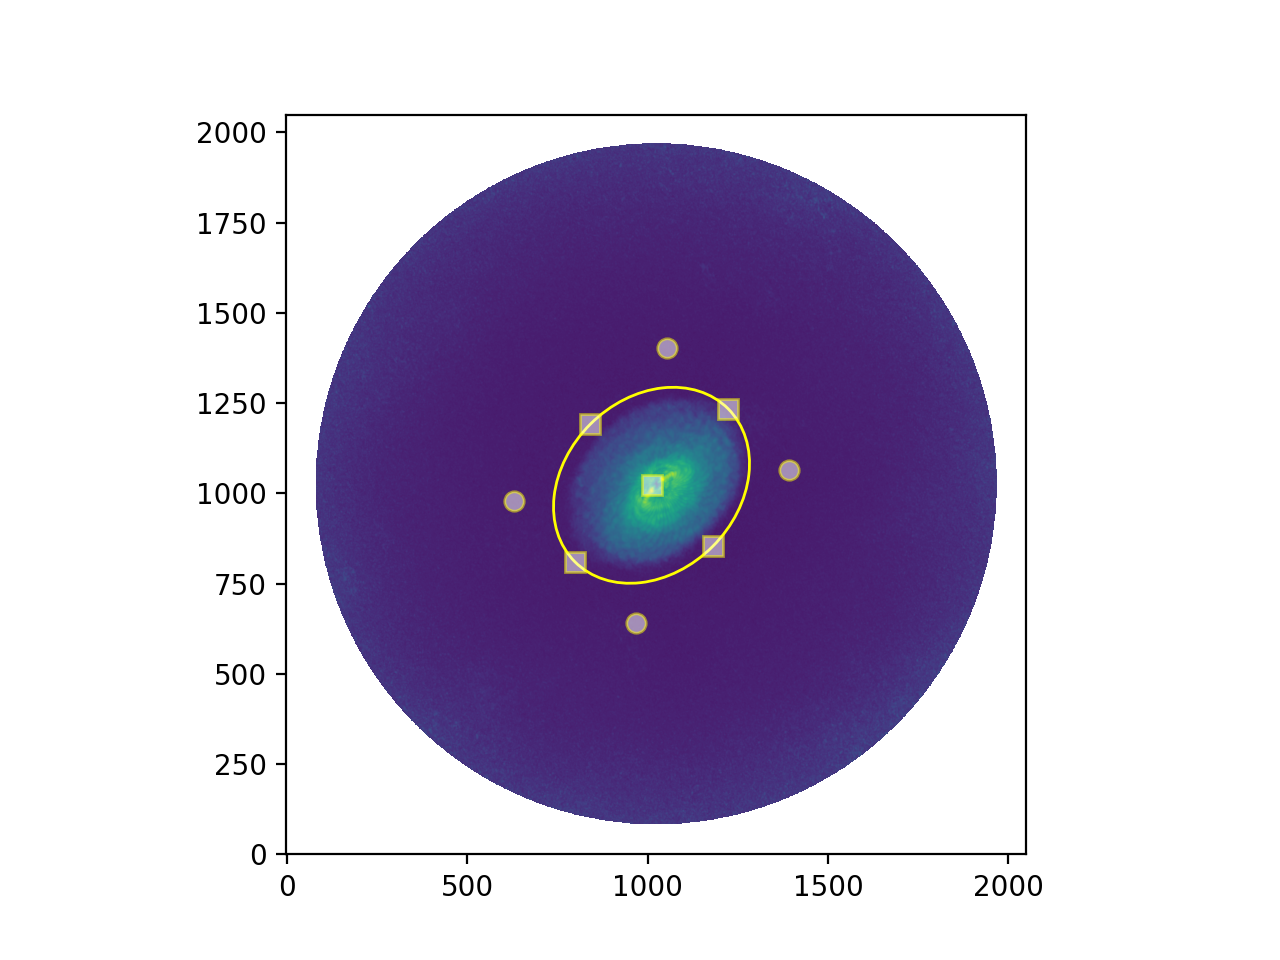

In [9]:
fig = pl.figure()
ax = fig.add_subplot()
img = ax.imshow(mx.value, origin='lower')

We can draw an ellipse around the disk to downselect only it:

In [10]:
import regions
center = regions.PixCoord(1000, 1000)
ellipse = regions.EllipsePixelRegion(center, width=600, height=500, angle=45*u.deg, visual={'color': 'yellow'})
selector = ellipse.as_mpl_selector(ax, sync=True, use_data_coordinates=True)

The `selector` has created a link to an interactive matplotlib widget that allows us to manually scale the ellipse, by dragging the points of the surrounding box, and to position it via the central anchor point. Pressing `r` toggles the rotation mode for the corner points (requires Matplotlib 3.6 or later); keeping `ctrl` pressed will resize around the center instead of the opposite handle, thus providing better control of the selector position. We can investigate the ellipse parameters once having drawn it to a satisfactory fit:

In [11]:
print(ellipse.center, ellipse.angle)
print(ellipse.bounding_box)

PixCoord(x=1011.0822510822511, y=1022.1645021645022) 45.0 deg
BoundingBox(ixmin=740, ixmax=1284, iymin=751, iymax=1295)


The `as_mpl_selector` method provides an optional `callback` parameter that can be used to specify a function, which will be called on each update to its region (i.e. every time the selector is modified). In the following example we will show how to use this for creating an image mask and keeping it update from the selector.

<IPython.core.display.Javascript object>


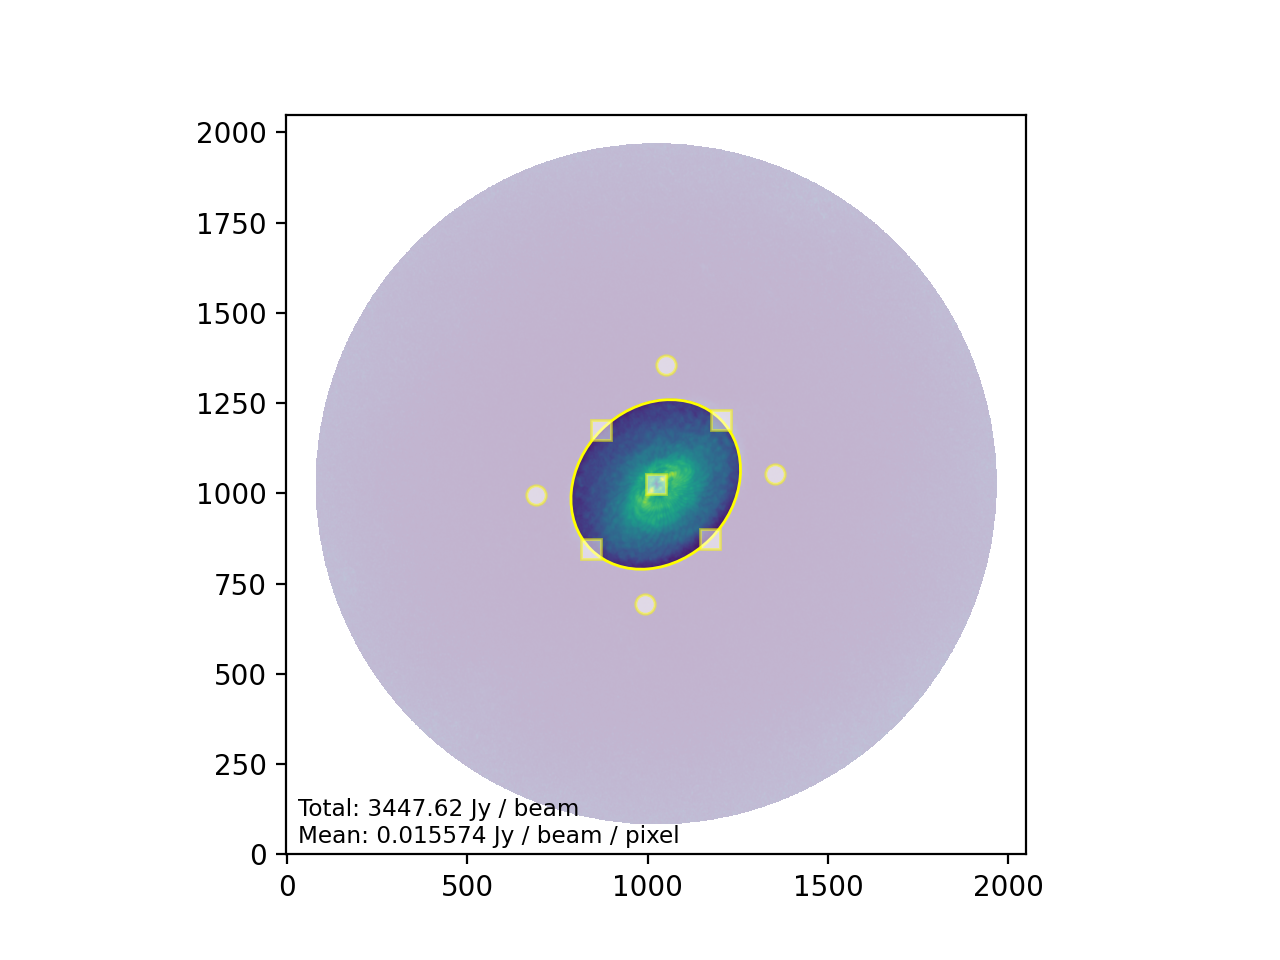

In [12]:
fig2 = pl.figure(2)
ax = fig2.add_subplot()
img = ax.imshow(mx.value, origin='lower', alpha=0.7)
text = ax.text(32, 32, '', size='small')

Our user-defined callback function generates a mask from the region and overlays it on the image as an alpha filter (keeping the areas outside shaded). We will also use this mask as an aperture to perform a quick flux integration in the `mx` layer, which is updated live in the `text` field as well.

In [13]:
def update_mask(region):
    mask = region.to_mask(mode='subpixels', subpixels=10)
    img.set_alpha((2*mask.to_image(mx.shape)+1)/3)
    flux = mask.multiply(mx)
    text.set_text(f'Total: {flux.sum():g}\nMean: {flux.mean():g} / pixel')

In [14]:
center = regions.PixCoord(960, 960)
ellipse = regions.EllipsePixelRegion(center, width=300, height=200, angle=45*u.deg, visual={'color': 'yellow'})
selector = ellipse.as_mpl_selector(ax, callback=update_mask, sync=True, use_data_coordinates=True)

We next make a cutout from the entire cube by creating a subcube using the ellipse region as a mask and inspect this subset:

In [15]:
cutout = cube.subcube_from_regions([ellipse])
print(cutout)
cutout.statistics()

DaskSpectralCube with shape=(127, 437, 437) and unit=Jy / beam and chunk size (127, 223, 224):
 n_x:    437  type_x: RA---SIN  unit_x: deg    range:   269.087321 deg:  269.089932 deg
 n_y:    437  type_y: DEC--SIN  unit_y: deg    range:   -21.957527 deg:  -21.955105 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz


{'npts': 18263616.0,
 'min': <Quantity -0.00421333 Jy / beam>,
 'max': <Quantity 0.06884712 Jy / beam>,
 'sum': <Quantity 14363.32788086 Jy / beam>,
 'sumsq': <Quantity 318.91756439 Jy2 / beam2>,
 'mean': <Quantity 0.00078644 Jy / beam>,
 'sigma': <Quantity 0.00410407 Jy / beam>,
 'rms': <Quantity 0.00417874 Jy / beam>}

Then we want to extract a position-velocity diagram across the disk.

We specify a width of 200 pixels (we could go to ~400) so we average across the short axis of the disk (note that `n_x` and drawn it to `n_y` are passed to `Path` in inverse order):

In [16]:
import pvextractor

In [17]:
path = pvextractor.Path([(0,0), cutout.shape[:0:-1]], width=250)

We show the path overlaid on our cutout disk:

<IPython.core.display.Javascript object>


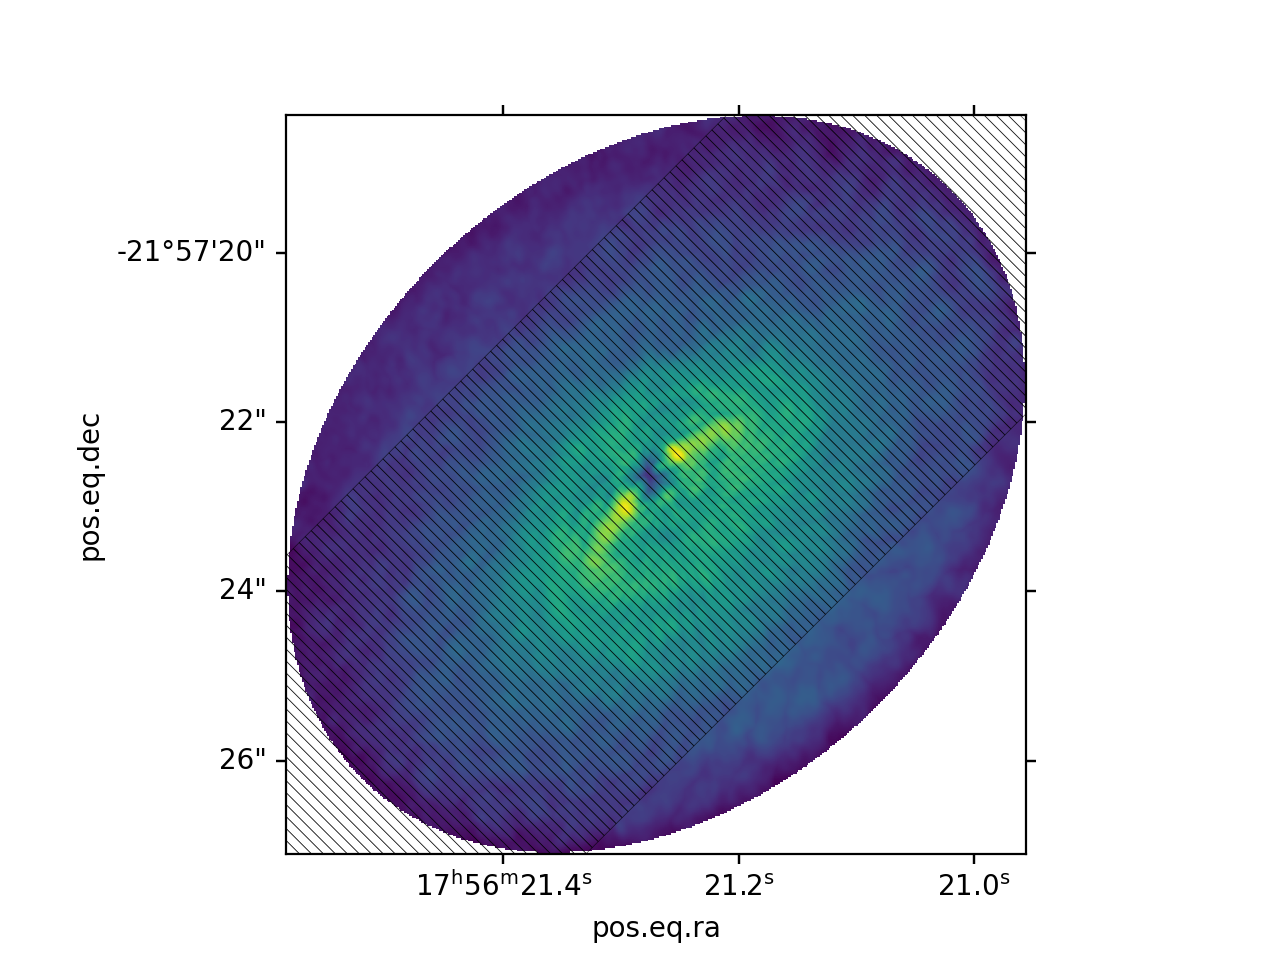

In [18]:
fig3 = pl.figure(3)
ax = fig3.add_subplot(111, projection=cutout.wcs.celestial)
ax.imshow(cutout.max(axis=0).value, origin='lower')
path.show_on_axis(ax, spacing=5, alpha=0.7, linewidth=0.25)

Then, we extract the PV diagram.  We choose spacing=5 to average over 5 pixels.  This averaging isn't necessary, but does make the operation a little faster and increases the signal-to-noise ratio per spatial bin.

In [19]:
pv = pvextractor.extract_pv_slice(cutout.with_spectral_unit(u.km/u.s, velocity_convention='radio'), path, spacing=5)

And plot the resulting diagram:

<IPython.core.display.Javascript object>


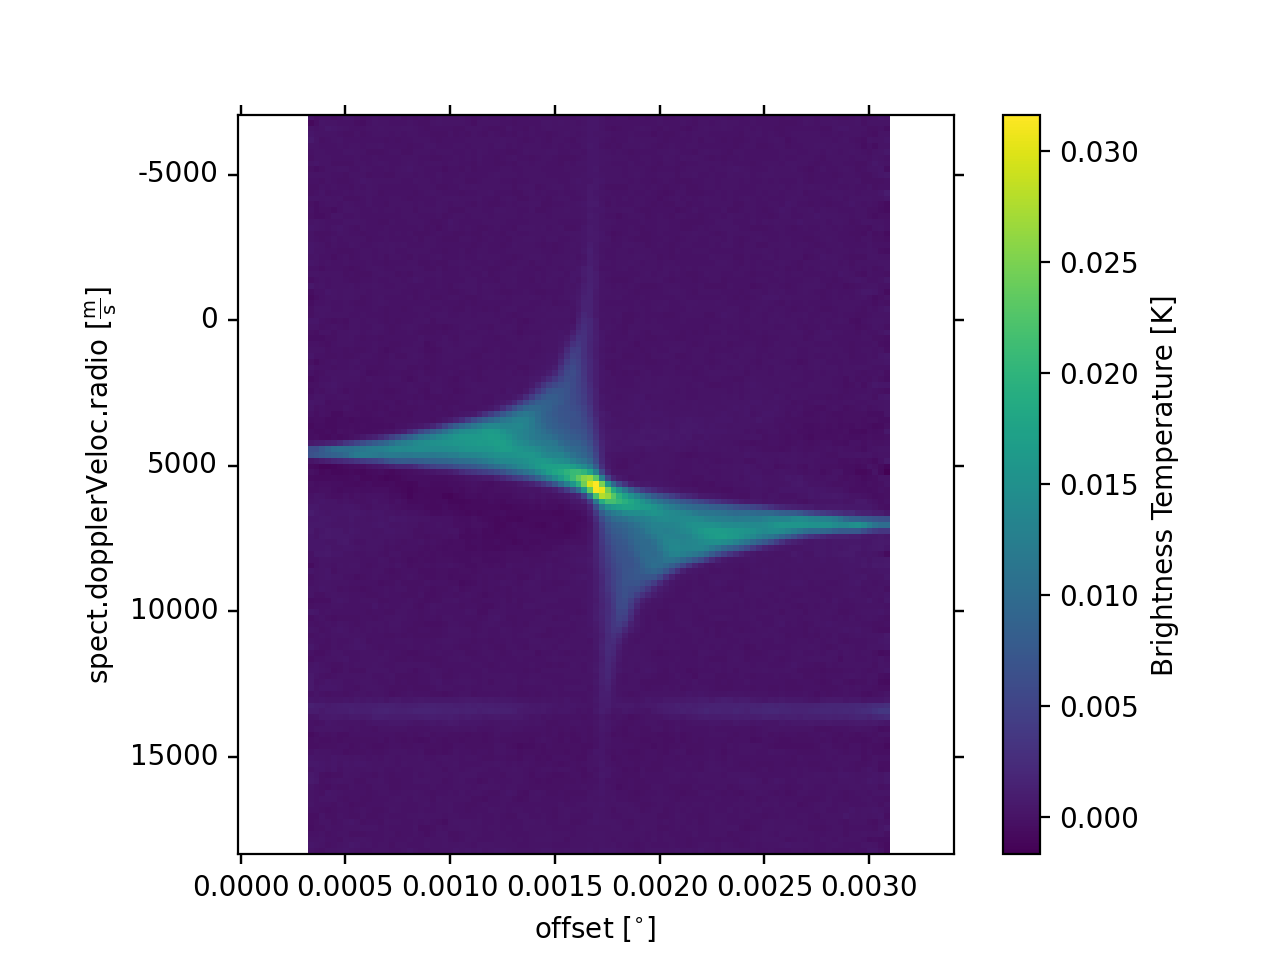

In [20]:
fig4 = pl.figure(4)
ax = fig4.add_subplot(111, projection=wcs.WCS(pv.header))
im = ax.imshow(pv.data)
cb = pl.colorbar(mappable=im, ax=ax)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(1)

# Second approach

We can also reproject the whole cube by rotating 45 degrees.

This requires making our own new header, which is a bit tedious, but effective.

In [21]:
header = cutout.wcs.to_header()
header['NAXIS'] = 3
header['NAXIS1'] = 600
header['NAXIS2'] = 400
header['NAXIS3'] = cutout.shape[0]
angle = 45*u.deg
header['CD1_1'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD2_1'] = -np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD1_2'] = np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD2_2'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD3_3'] = cube.wcs.wcs.cdelt[2]
header['CRPIX1'] = 300
header['CRPIX2'] = 200

We then reproject the whole cube, which takes a minute or two:

In [22]:
reproj = cutout.reproject(header)

In [23]:
reproj

DaskSpectralCube with shape=(127, 400, 600) and unit=Jy / beam and chunk size (127, 200, 300):
 n_x:    600  type_x: RA---SIN  unit_x: deg    range:   269.086547 deg:  269.090774 deg
 n_y:    400  type_y: DEC--SIN  unit_y: deg    range:   -21.958249 deg:  -21.954328 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [24]:
rmax = reproj.max(axis=0)

<IPython.core.display.Javascript object>


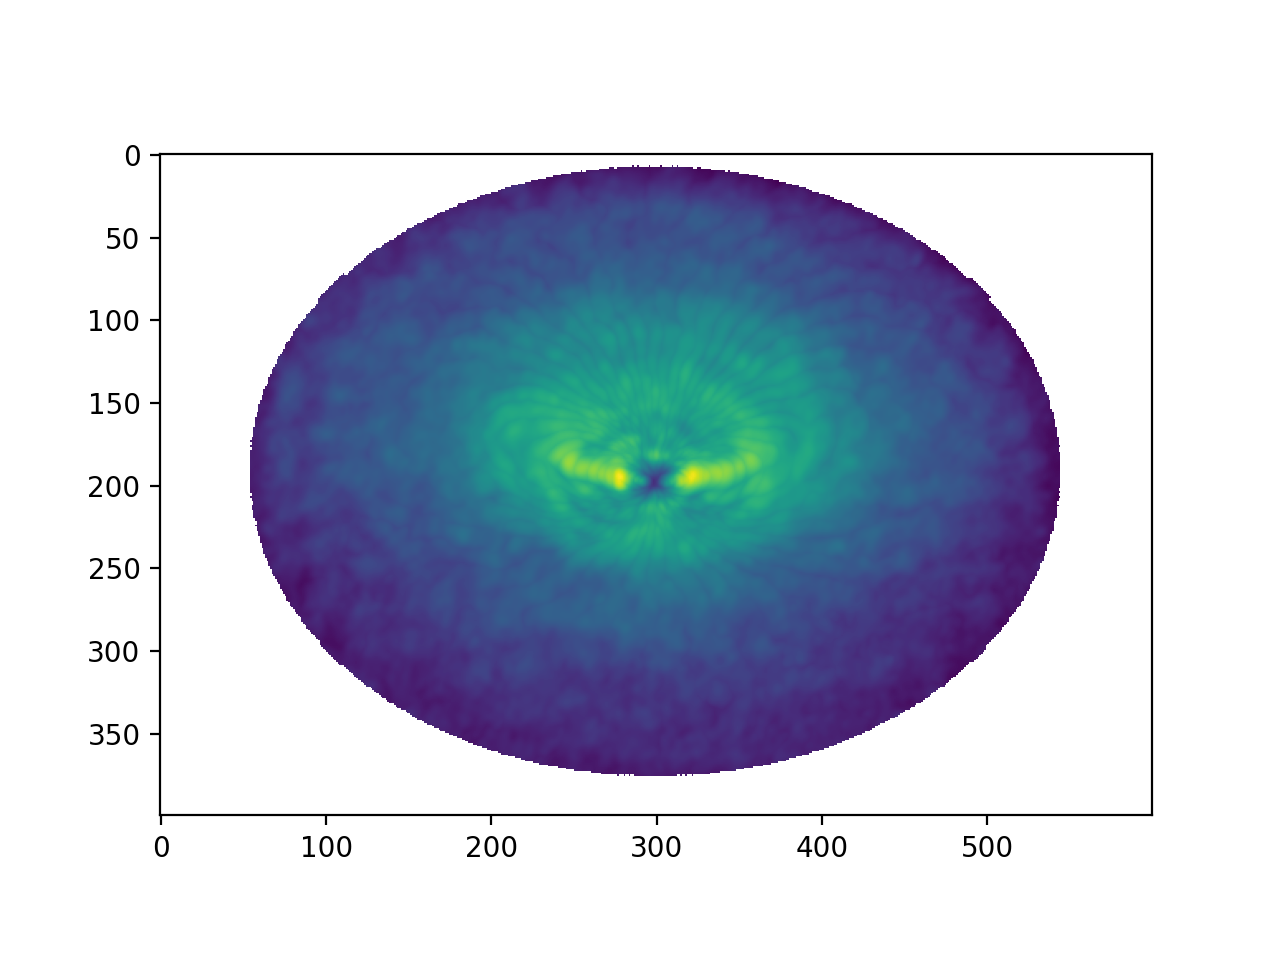

In [25]:
rmax.quicklook()

Then, the position-velocity diagram is easy: we just take the average along the short axis:

In [26]:
pv2 = reproj.with_spectral_unit(u.km/u.s, velocity_convention='radio').mean(axis=1)

<IPython.core.display.Javascript object>


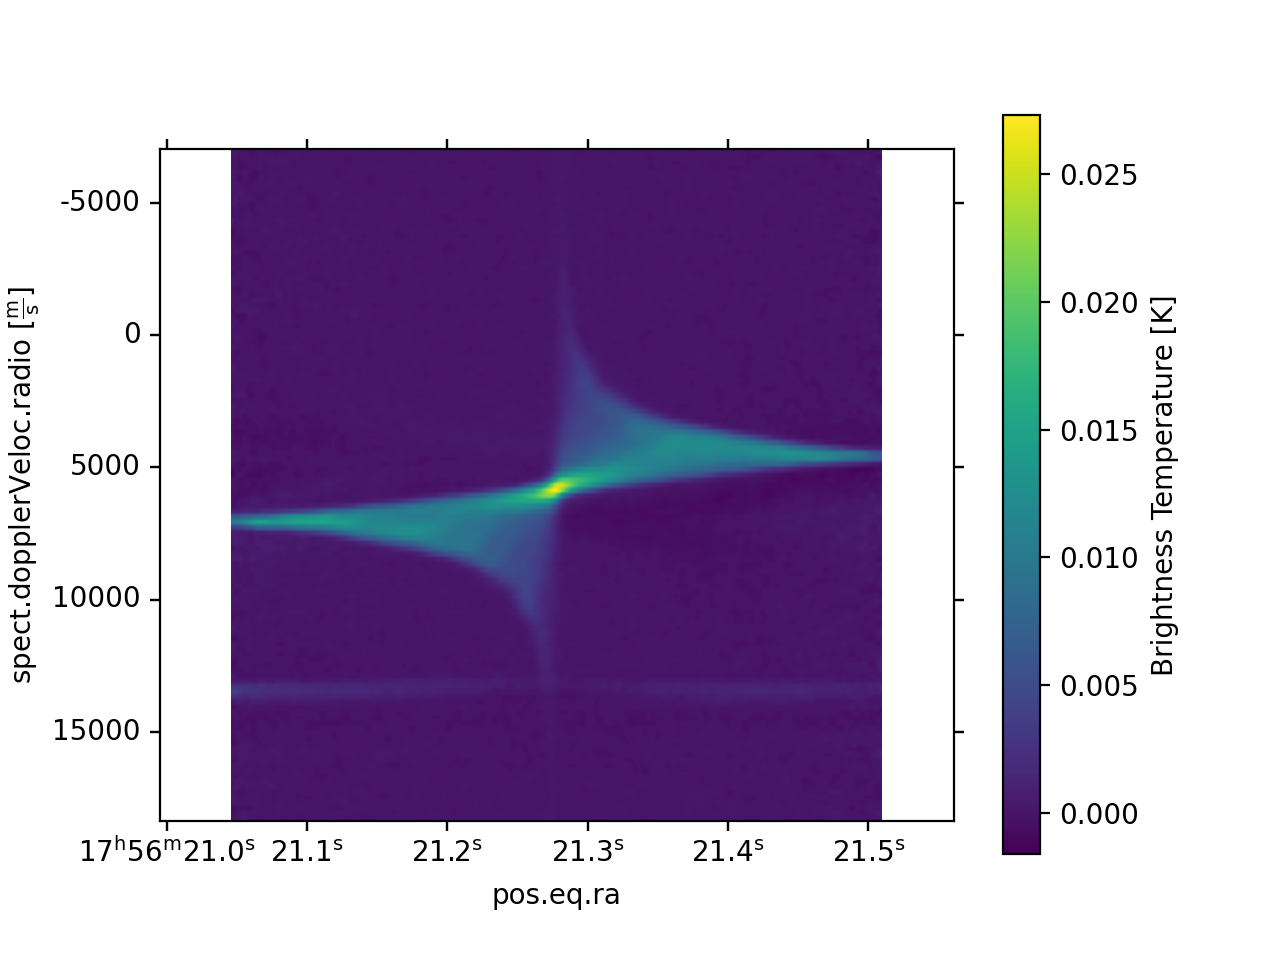

In [27]:
fig5 = pl.figure(5)
ax = fig5.add_subplot(111, projection=wcs.WCS(pv2.header))
im = ax.imshow(pv2.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(4)